<a href="https://colab.research.google.com/github/guddushah/Predicting-Air-Quality-Standards-in-the-USA-using-Pyspark/blob/main/Air_Quality_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Creating SparkSession
import findspark
findspark.init()

import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()

df = spark.sql('''select 'world' as hello ''')
df.show()

+-----+
|hello|
+-----+
|world|
+-----+



In [ ]:
spark

In [ ]:
#Loading the dataset
df_pyspark = spark.read.csv("F:\BigData_Assignment\AirQualityDataset.csv",header = True, inferSchema = True)

In [ ]:
#Removing messiness of dataframe
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [ ]:
#Displaying dataset
df_pyspark.show(5)

+---+---------+--------+---+--------+------------------+-------------------------+----------+--------+----------+-------+---------+----------+-------+-------------------+
|_c0|CBSA Code|    Date|AQI|Category|Defining Parameter|Number of Sites Reporting|city_ascii|state_id|state_name|    lat|      lng|population|density|           timezone|
+---+---------+--------+---+--------+------------------+-------------------------+----------+--------+----------+-------+---------+----------+-------+-------------------+
|  0|    10140|1/1/2022| 21|    Good|             PM2.5|                        2|  Aberdeen|      WA|Washington|46.9757|-123.8094|     16571|    588|America/Los_Angeles|
|  1|    10140|1/2/2022| 12|    Good|             PM2.5|                        2|  Aberdeen|      WA|Washington|46.9757|-123.8094|     16571|    588|America/Los_Angeles|
|  2|    10140|1/3/2022| 18|    Good|             PM2.5|                        2|  Aberdeen|      WA|Washington|46.9757|-123.8094|     16571|   

In [ ]:
#checking dataframe type
type(df_pyspark)

pyspark.sql.dataframe.DataFrame

# Data Pre-Processing

In [ ]:
print(df_pyspark.columns)

['_c0', 'CBSA Code', 'Date', 'AQI', 'Category', 'Defining Parameter', 'Number of Sites Reporting', 'city_ascii', 'state_id', 'state_name', 'lat', 'lng', 'population', 'density', 'timezone']


In [ ]:
#Renaming the columns name
df_pyspark = df_pyspark.withColumnRenamed("_c0", "Index")\
             .withColumnRenamed("CBSA Code", "CBSA_Code")\
             .withColumnRenamed("Defining Parameter", "Defining_Parameter")\
             .withColumnRenamed("Number of Sites Reporting", "Number_of_Sites")\
             .withColumnRenamed("city_ascii", "city_name")

In [ ]:
df_pyspark.columns

['Index',
 'CBSA_Code',
 'Date',
 'AQI',
 'Category',
 'Defining_Parameter',
 'Number_of_Sites',
 'city_name',
 'state_id',
 'state_name',
 'lat',
 'lng',
 'population',
 'density',
 'timezone']

In [ ]:
#Number of records
df_pyspark.count()

1048575

In [ ]:
#Size of data
(df_pyspark.count(), len(df_pyspark.columns))

(1048575, 15)

In [ ]:
#Checking the datatypes of columns/features
df_pyspark.printSchema()

root
 |-- Index: integer (nullable = true)
 |-- CBSA_Code: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- AQI: integer (nullable = true)
 |-- Category: string (nullable = true)
 |-- Defining_Parameter: string (nullable = true)
 |-- Number_of_Sites: integer (nullable = true)
 |-- city_name: string (nullable = true)
 |-- state_id: string (nullable = true)
 |-- state_name: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lng: double (nullable = true)
 |-- population: integer (nullable = true)
 |-- density: integer (nullable = true)
 |-- timezone: string (nullable = true)



In [ ]:
#check datatypes
df_pyspark.dtypes

[('Index', 'int'),
 ('CBSA_Code', 'int'),
 ('Date', 'string'),
 ('AQI', 'int'),
 ('Category', 'string'),
 ('Defining_Parameter', 'string'),
 ('Number_of_Sites', 'int'),
 ('city_name', 'string'),
 ('state_id', 'string'),
 ('state_name', 'string'),
 ('lat', 'double'),
 ('lng', 'double'),
 ('population', 'int'),
 ('density', 'int'),
 ('timezone', 'string')]

In [ ]:
df_pyspark.describe().show()

+-------+-----------------+------------------+--------+------------------+--------------+------------------+------------------+---------+--------+----------+-----------------+------------------+------------------+------------------+-----------------+
|summary|            Index|         CBSA_Code|    Date|               AQI|      Category|Defining_Parameter|   Number_of_Sites|city_name|state_id|state_name|              lat|               lng|        population|           density|         timezone|
+-------+-----------------+------------------+--------+------------------+--------------+------------------+------------------+---------+--------+----------+-----------------+------------------+------------------+------------------+-----------------+
|  count|          1048575|           1048575| 1048575|           1048575|       1048575|           1048575|           1048575|  1048575| 1048575|   1048575|          1048575|           1048575|           1048575|           1048575|          10485

In [ ]:
#check for missing data
from pyspark.sql.functions import isnan, when, count, col
df = df_pyspark.select([count(when(isnan(c), c)).alias(c) for c in df_pyspark.columns])
df.show()

+-----+---------+----+---+--------+------------------+---------------+---------+--------+----------+---+---+----------+-------+--------+
|Index|CBSA_Code|Date|AQI|Category|Defining_Parameter|Number_of_Sites|city_name|state_id|state_name|lat|lng|population|density|timezone|
+-----+---------+----+---+--------+------------------+---------------+---------+--------+----------+---+---+----------+-------+--------+
|    0|        0|   0|  0|       0|                 0|              0|        0|       0|         0|  0|  0|         0|      0|       0|
+-----+---------+----+---+--------+------------------+---------------+---------+--------+----------+---+---+----------+-------+--------+



In [ ]:
#Grouping by class
df_pyspark.groupby('Category').count().sort('count', ascending = True).show()

+--------------------+------+
|            Category| count|
+--------------------+------+
|           Hazardous|   252|
|      Very Unhealthy|   628|
|           Unhealthy|  3631|
|Unhealthy for Sen...| 13952|
|            Moderate|210660|
|                Good|819452|
+--------------------+------+



In [ ]:
#pollutants concenteration
df_pyspark.groupby('Defining_Parameter').count().sort('count', ascending = True).show()

+------------------+------+
|Defining_Parameter| count|
+------------------+------+
|                CO|   630|
|               NO2| 10291|
|              PM10| 44808|
|             PM2.5|437601|
|             Ozone|555245|
+------------------+------+



In [ ]:
#total number of timezone
df_pyspark.select('timezone').distinct().count()

14

In [ ]:
#timezone with number of times where measurement was taken
df_pyspark.groupby('timezone').count().sort('count', ascending = True).show()

+--------------------+------+
|            timezone| count|
+--------------------+------+
|      America/Juneau|  2093|
|America/Indiana/V...|  2962|
|   America/Matamoros|  4365|
|   America/Anchorage|  4749|
| America/Puerto_Rico|  5780|
|    Pacific/Honolulu|  6604|
|       America/Boise|  8411|
|     America/Phoenix| 20428|
|America/Indiana/I...| 26876|
|     America/Detroit| 30342|
|      America/Denver|105141|
| America/Los_Angeles|178542|
|     America/Chicago|299330|
|    America/New_York|352952|
+--------------------+------+



In [ ]:
df_pyspark.show(5)

+-----+---------+--------+---+--------+------------------+---------------+---------+--------+----------+-------+---------+----------+-------+-------------------+
|Index|CBSA_Code|    Date|AQI|Category|Defining_Parameter|Number_of_Sites|city_name|state_id|state_name|    lat|      lng|population|density|           timezone|
+-----+---------+--------+---+--------+------------------+---------------+---------+--------+----------+-------+---------+----------+-------+-------------------+
|    0|    10140|1/1/2022| 21|    Good|             PM2.5|              2| Aberdeen|      WA|Washington|46.9757|-123.8094|     16571|    588|America/Los_Angeles|
|    1|    10140|1/2/2022| 12|    Good|             PM2.5|              2| Aberdeen|      WA|Washington|46.9757|-123.8094|     16571|    588|America/Los_Angeles|
|    2|    10140|1/3/2022| 18|    Good|             PM2.5|              2| Aberdeen|      WA|Washington|46.9757|-123.8094|     16571|    588|America/Los_Angeles|
|    3|    10140|1/4/2022| 1

In [ ]:
#total number of cities
df_pyspark.select('city_name').distinct().count()

482

In [ ]:
#city name with number of times where measurement was taken
df_pyspark.groupby('city_name').count().sort('count', ascending = True).show()

+----------+-----+
| city_name|count|
+----------+-----+
|   Beckley|   25|
|  Coos Bay|  107|
| Jonesboro|  139|
|   Gaffney|  172|
| Talladega|  233|
|   Guayama|  249|
|  Beatrice|  303|
|   Grenada|  317|
| Greenwood|  320|
|  Danville|  425|
|      Ames|  425|
|  Adjuntas|  443|
| Tahlequah|  549|
|  Fairmont|  590|
|    Durant|  595|
|   Ruidoso|  611|
|    Winona|  634|
|Los Alamos|  638|
|   Emporia|  640|
|  Houghton|  640|
+----------+-----+
only showing top 20 rows



In [ ]:
#total number of states
df_pyspark.select('state_name').distinct().count()

52

In [ ]:
#state name with number of times where measurement was taken
df_pyspark.groupby('state_name').count().sort('count', ascending = True).show()

+--------------------+-----+
|          state_name|count|
+--------------------+-----+
|            Delaware| 2085|
|        Rhode Island| 2282|
|District of Columbia| 2289|
|             Vermont| 4384|
|         Puerto Rico| 5780|
|              Hawaii| 6604|
|            Nebraska| 6796|
|              Alaska| 6842|
|          New Jersey| 6975|
|              Kansas| 7068|
|            Maryland| 9303|
|               Maine|10702|
|         Connecticut|10871|
|        North Dakota|11057|
|       Massachusetts|11163|
|         Mississippi|11976|
|        South Dakota|12193|
|       New Hampshire|12486|
|            Arkansas|13782|
|       West Virginia|13805|
+--------------------+-----+
only showing top 20 rows



In [ ]:
df_pyspark.groupby('Date').count().sort('count', ascending = False).show()

+---------+-----+
|     Date|count|
+---------+-----+
|3/20/2017|  509|
|5/19/2017|  507|
|3/26/2017|  507|
|7/30/2017|  507|
| 3/5/2017|  506|
|4/25/2017|  506|
|8/28/2016|  506|
|9/27/2016|  506|
|3/11/2017|  506|
|4/13/2017|  506|
|6/30/2017|  506|
| 3/8/2017|  506|
| 8/5/2017|  505|
| 7/7/2018|  505|
| 5/7/2017|  505|
|3/17/2017|  505|
|6/24/2017|  505|
|5/13/2017|  505|
|5/16/2017|  505|
|5/22/2017|  505|
+---------+-----+
only showing top 20 rows



In [ ]:
df_pyspark.printSchema()

root
 |-- Index: integer (nullable = true)
 |-- CBSA_Code: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- AQI: integer (nullable = true)
 |-- Category: string (nullable = true)
 |-- Defining_Parameter: string (nullable = true)
 |-- Number_of_Sites: integer (nullable = true)
 |-- city_name: string (nullable = true)
 |-- state_id: string (nullable = true)
 |-- state_name: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lng: double (nullable = true)
 |-- population: integer (nullable = true)
 |-- density: integer (nullable = true)
 |-- timezone: string (nullable = true)



# Feature Engineering

In [ ]:
#Cast Date from string to date
import pyspark.sql.functions as F
df_pyspark = df_pyspark.withColumn(
     "Date",
      F.when(
          F.to_date(F.col("Date"), "MM/dd/yyyy").isNotNull(),
          F.to_date(F.col("Date"), "MM/dd/yyyy"),
      )
)

In [ ]:
#Cast CBSA_Code from integer to string
from pyspark.sql.types import StringType
df_pyspark = df_pyspark.withColumn('Index', df_pyspark['Index'].cast(StringType()))
df_pyspark = df_pyspark.withColumn('CBSA_Code', df_pyspark['CBSA_Code'].cast(StringType()))

In [ ]:
df_pyspark.printSchema()

root
 |-- Index: string (nullable = true)
 |-- CBSA_Code: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- AQI: integer (nullable = true)
 |-- Category: string (nullable = true)
 |-- Defining_Parameter: string (nullable = true)
 |-- Number_of_Sites: integer (nullable = true)
 |-- city_name: string (nullable = true)
 |-- state_id: string (nullable = true)
 |-- state_name: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lng: double (nullable = true)
 |-- population: integer (nullable = true)
 |-- density: integer (nullable = true)
 |-- timezone: string (nullable = true)



In [ ]:
#Label Encoding
#Encoding for Defining_Parameter
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer


parameterEncoder = StringIndexer(inputCol = 'Defining_Parameter', outputCol = 'Pollutant_Parameter').fit(df_pyspark)
df_pyspark = parameterEncoder.transform(df_pyspark)

In [ ]:
#Encoding for Category
catEncoder = StringIndexer(inputCol = 'Category', outputCol = 'Target').fit(df_pyspark)
df_pyspark = catEncoder.transform(df_pyspark)

In [ ]:
#Get the labels
parameterEncoder.labels

['Ozone', 'PM2.5', 'PM10', 'NO2', 'CO']

In [ ]:
catEncoder.labels

['Good',
 'Moderate',
 'Unhealthy for Sensitive Groups',
 'Unhealthy',
 'Very Unhealthy',
 'Hazardous']

In [ ]:
import pyspark.sql.functions as f
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY") # this bit
#resolves the issues

DataFrame[key: string, value: string]

In [ ]:
df_pyspark.show(5)

+-----+---------+----------+---+--------+------------------+---------------+---------+--------+----------+-------+---------+----------+-------+-------------------+-------------------+------+
|Index|CBSA_Code|      Date|AQI|Category|Defining_Parameter|Number_of_Sites|city_name|state_id|state_name|    lat|      lng|population|density|           timezone|Pollutant_Parameter|Target|
+-----+---------+----------+---+--------+------------------+---------------+---------+--------+----------+-------+---------+----------+-------+-------------------+-------------------+------+
|    0|    10140|2022-01-01| 21|    Good|             PM2.5|              2| Aberdeen|      WA|Washington|46.9757|-123.8094|     16571|    588|America/Los_Angeles|                1.0|   0.0|
|    1|    10140|2022-01-02| 12|    Good|             PM2.5|              2| Aberdeen|      WA|Washington|46.9757|-123.8094|     16571|    588|America/Los_Angeles|                1.0|   0.0|
|    2|    10140|2022-01-03| 18|    Good|    

In [ ]:
from pyspark.sql.functions import format_number, dayofmonth, dayofyear, month, year, weekofyear, date_format

In [ ]:
df_pyspark.select(year(df_pyspark['Date'])).show(5)

+----------+
|year(Date)|
+----------+
|      2022|
|      2022|
|      2022|
|      2022|
|      2022|
+----------+
only showing top 5 rows



In [ ]:
df_pyspark.select(dayofmonth(df_pyspark['Date'])).show(5)

+----------------+
|dayofmonth(Date)|
+----------------+
|               1|
|               2|
|               3|
|               4|
|               5|
+----------------+
only showing top 5 rows



In [ ]:
df_pyspark.select(month(df_pyspark['Date'])).show(5)

+-----------+
|month(Date)|
+-----------+
|          1|
|          1|
|          1|
|          1|
|          1|
+-----------+
only showing top 5 rows



In [ ]:
#from pyspark.sql.functions import *
#from pyspark.sql.types import *

# udf that recognise pattern and return list of year,month and day
#def splitUDF(row):
 #   if "/" in row:
  #      mm,dd,yyyy = row.split("/")
   # elif "-" in row:
    #    yyyy,mm,dd = row.split("-")

    #return [yyyy,mm,dd]


#dateSplitterUDF = udf(lambda row : splitUDF(row),ArrayType(StringType()))
#df\
#.select(dateSplitterUDF(df.Date).alias("dt"))\
#.withColumn('year',col('dt').getItem(0).cast('int'))\
#.withColumn('month',col('dt').getItem(1).cast('int'))\
#.withColumn('day',col('dt').getItem(2).cast('int'))\
#.show()


In [ ]:
#return list of year,month and day
from pyspark.sql.functions import *
from pyspark.sql.functions import year, month, dayofweek, dayofmonth
df_pyspark = df_pyspark.withColumn('year', year(col('Date')))
df_pyspark = df_pyspark.withColumn('month', month(col('Date')))
df_pyspark = df_pyspark.withColumn('dayofmonth', dayofmonth(col('Date')))

In [ ]:
df_pyspark.show(5)

+-----+---------+----------+---+--------+------------------+---------------+---------+--------+----------+-------+---------+----------+-------+-------------------+-------------------+------+----+-----+----------+
|Index|CBSA_Code|      Date|AQI|Category|Defining_Parameter|Number_of_Sites|city_name|state_id|state_name|    lat|      lng|population|density|           timezone|Pollutant_Parameter|Target|year|month|dayofmonth|
+-----+---------+----------+---+--------+------------------+---------------+---------+--------+----------+-------+---------+----------+-------+-------------------+-------------------+------+----+-----+----------+
|    0|    10140|2022-01-01| 21|    Good|             PM2.5|              2| Aberdeen|      WA|Washington|46.9757|-123.8094|     16571|    588|America/Los_Angeles|                1.0|   0.0|2022|    1|         1|
|    1|    10140|2022-01-02| 12|    Good|             PM2.5|              2| Aberdeen|      WA|Washington|46.9757|-123.8094|     16571|    588|Ameri

In [ ]:
df_pyspark.printSchema()

root
 |-- Index: string (nullable = true)
 |-- CBSA_Code: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- AQI: integer (nullable = true)
 |-- Category: string (nullable = true)
 |-- Defining_Parameter: string (nullable = true)
 |-- Number_of_Sites: integer (nullable = true)
 |-- city_name: string (nullable = true)
 |-- state_id: string (nullable = true)
 |-- state_name: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lng: double (nullable = true)
 |-- population: integer (nullable = true)
 |-- density: integer (nullable = true)
 |-- timezone: string (nullable = true)
 |-- Pollutant_Parameter: double (nullable = false)
 |-- Target: double (nullable = false)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- dayofmonth: integer (nullable = true)



In [ ]:
print(df_pyspark.columns)

['Index', 'CBSA_Code', 'Date', 'AQI', 'Category', 'Defining_Parameter', 'Number_of_Sites', 'city_name', 'state_id', 'state_name', 'lat', 'lng', 'population', 'density', 'timezone', 'Pollutant_Parameter', 'Target', 'year', 'month', 'dayofmonth']


# Feature Selection

In [ ]:
selected_features = ['year', 'month', 'dayofmonth', 'AQI', 'Pollutant_Parameter','Number_of_Sites', 'lat','lng',
                     'population','density']

In [ ]:
#VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
vec_assembler = VectorAssembler(inputCols = selected_features, outputCol = "features")

In [ ]:
vec_df = vec_assembler.transform(df_pyspark)
vec_df.show(5)

+-----+---------+----------+---+--------+------------------+---------------+---------+--------+----------+-------+---------+----------+-------+-------------------+-------------------+------+----+-----+----------+--------------------+
|Index|CBSA_Code|      Date|AQI|Category|Defining_Parameter|Number_of_Sites|city_name|state_id|state_name|    lat|      lng|population|density|           timezone|Pollutant_Parameter|Target|year|month|dayofmonth|            features|
+-----+---------+----------+---+--------+------------------+---------------+---------+--------+----------+-------+---------+----------+-------+-------------------+-------------------+------+----+-----+----------+--------------------+
|    0|    10140|2022-01-01| 21|    Good|             PM2.5|              2| Aberdeen|      WA|Washington|46.9757|-123.8094|     16571|    588|America/Los_Angeles|                1.0|   0.0|2022|    1|         1|[2022.0,1.0,1.0,2...|
|    1|    10140|2022-01-02| 12|    Good|             PM2.5|    

In [ ]:
vec_df.select('features').show()

+--------------------+
|            features|
+--------------------+
|[2022.0,1.0,1.0,2...|
|[2022.0,1.0,2.0,1...|
|[2022.0,1.0,3.0,1...|
|[2022.0,1.0,4.0,1...|
|[2022.0,1.0,5.0,1...|
|[2022.0,1.0,6.0,1...|
|[2022.0,1.0,7.0,2...|
|[2022.0,1.0,8.0,1...|
|[2022.0,1.0,9.0,1...|
|[2022.0,1.0,10.0,...|
|[2022.0,1.0,11.0,...|
|[2022.0,1.0,12.0,...|
|[2022.0,1.0,13.0,...|
|[2022.0,1.0,14.0,...|
|[2022.0,1.0,15.0,...|
|[2022.0,1.0,16.0,...|
|[2022.0,1.0,17.0,...|
|[2022.0,1.0,18.0,...|
|[2022.0,1.0,19.0,...|
|[2022.0,1.0,20.0,...|
+--------------------+
only showing top 20 rows



In [ ]:
df_pyspark.select('year').distinct().count()

8

In [ ]:
df_pyspark.groupby('year').count().sort('year', ascending = True).show()

+----+------+
|year| count|
+----+------+
|2015| 14456|
|2016|167092|
|2017|170310|
|2018|169909|
|2019|167492|
|2020|166852|
|2021|166633|
|2022| 25831|
+----+------+



In [ ]:
df_pyspark.groupby('month').count().sort('month', ascending = True).show()

+-----+-----+
|month|count|
+-----+-----+
|    1|91115|
|    2|81955|
|    3|94969|
|    4|88792|
|    5|90199|
|    6|86894|
|    7|89705|
|    8|89847|
|    9|86438|
|   10|88058|
|   11|79065|
|   12|81538|
+-----+-----+



In [ ]:
df_pyspark.groupby('dayofmonth').count().sort('dayofmonth', ascending = True).show()

+----------+-----+
|dayofmonth|count|
+----------+-----+
|         1|34470|
|         2|34421|
|         3|34526|
|         4|34424|
|         5|34425|
|         6|34526|
|         7|34398|
|         8|34407|
|         9|34494|
|        10|34356|
|        11|34359|
|        12|34468|
|        13|34391|
|        14|34399|
|        15|34514|
|        16|34378|
|        17|34372|
|        18|34514|
|        19|34408|
|        20|34427|
+----------+-----+
only showing top 20 rows



Train-Test split by date

In [ ]:
train_df = vec_df.filter(F.col("Date").between("2015-01-01","2019-12-31"))
test_df = vec_df.filter(F.col("Date") > "2019-12-31")

In [ ]:
train_df.count()

689259

In [ ]:
train_df.show(2)

+------+---------+----------+---+--------+------------------+---------------+---------+--------+------------+-------+--------+----------+-------+---------------+-------------------+------+----+-----+----------+--------------------+
| Index|CBSA_Code|      Date|AQI|Category|Defining_Parameter|Number_of_Sites|city_name|state_id|  state_name|    lat|     lng|population|density|       timezone|Pollutant_Parameter|Target|year|month|dayofmonth|            features|
+------+---------+----------+---+--------+------------------+---------------+---------+--------+------------+-------+--------+----------+-------+---------------+-------------------+------+----+-----+----------+--------------------+
|365468|    10100|2019-01-03|  4|    Good|              PM10|              1| Aberdeen|      SD|South Dakota|45.4649|-98.4686|     28315|    661|America/Chicago|                2.0|   0.0|2019|    1|         3|[2019.0,1.0,3.0,4...|
|365469|    10100|2019-01-06| 31|    Good|             PM2.5|           

In [ ]:
test_df.count()

359316

In [ ]:
test_df.show(2)

+-----+---------+----------+---+--------+------------------+---------------+---------+--------+----------+-------+---------+----------+-------+-------------------+-------------------+------+----+-----+----------+--------------------+
|Index|CBSA_Code|      Date|AQI|Category|Defining_Parameter|Number_of_Sites|city_name|state_id|state_name|    lat|      lng|population|density|           timezone|Pollutant_Parameter|Target|year|month|dayofmonth|            features|
+-----+---------+----------+---+--------+------------------+---------------+---------+--------+----------+-------+---------+----------+-------+-------------------+-------------------+------+----+-----+----------+--------------------+
|    0|    10140|2022-01-01| 21|    Good|             PM2.5|              2| Aberdeen|      WA|Washington|46.9757|-123.8094|     16571|    588|America/Los_Angeles|                1.0|   0.0|2022|    1|         1|[2022.0,1.0,1.0,2...|
|    1|    10140|2022-01-02| 12|    Good|             PM2.5|    

# Model Building

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

DecisionTree Classifier

In [ ]:
dec_tree = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'Target')

In [ ]:
dec_tree_model = dec_tree.fit(train_df)

In [ ]:
y_pred = dec_tree_model.transform(test_df)

In [ ]:
y_pred.show(5)

+-----+---------+----------+---+--------+------------------+---------------+---------+--------+----------+-------+---------+----------+-------+-------------------+-------------------+------+----+-----+----------+--------------------+--------------------+--------------------+----------+
|Index|CBSA_Code|      Date|AQI|Category|Defining_Parameter|Number_of_Sites|city_name|state_id|state_name|    lat|      lng|population|density|           timezone|Pollutant_Parameter|Target|year|month|dayofmonth|            features|       rawPrediction|         probability|prediction|
+-----+---------+----------+---+--------+------------------+---------------+---------+--------+----------+-------+---------+----------+-------+-------------------+-------------------+------+----+-----+----------+--------------------+--------------------+--------------------+----------+
|    0|    10140|2022-01-01| 21|    Good|             PM2.5|              2| Aberdeen|      WA|Washington|46.9757|-123.8094|     16571|    

In [ ]:
print(y_pred.columns)

['Index', 'CBSA_Code', 'Date', 'AQI', 'Category', 'Defining_Parameter', 'Number_of_Sites', 'city_name', 'state_id', 'state_name', 'lat', 'lng', 'population', 'density', 'timezone', 'Pollutant_Parameter', 'Target', 'year', 'month', 'dayofmonth', 'features', 'rawPrediction', 'probability', 'prediction']


In [ ]:
y_pred.select('Target','rawPrediction', 'probability', 'prediction').show()

+------+--------------------+--------------------+----------+
|Target|       rawPrediction|         probability|prediction|
+------+--------------------+--------------------+----------+
|   0.0|[523990.0,0.0,0.0...|[1.0,0.0,0.0,0.0,...|       0.0|
|   0.0|[523990.0,0.0,0.0...|[1.0,0.0,0.0,0.0,...|       0.0|
|   0.0|[523990.0,0.0,0.0...|[1.0,0.0,0.0,0.0,...|       0.0|
|   0.0|[523990.0,0.0,0.0...|[1.0,0.0,0.0,0.0,...|       0.0|
|   0.0|[523990.0,0.0,0.0...|[1.0,0.0,0.0,0.0,...|       0.0|
|   0.0|[523990.0,0.0,0.0...|[1.0,0.0,0.0,0.0,...|       0.0|
|   0.0|[523990.0,0.0,0.0...|[1.0,0.0,0.0,0.0,...|       0.0|
|   0.0|[523990.0,0.0,0.0...|[1.0,0.0,0.0,0.0,...|       0.0|
|   0.0|[523990.0,0.0,0.0...|[1.0,0.0,0.0,0.0,...|       0.0|
|   0.0|[523990.0,0.0,0.0...|[1.0,0.0,0.0,0.0,...|       0.0|
|   0.0|[523990.0,0.0,0.0...|[1.0,0.0,0.0,0.0,...|       0.0|
|   0.0|[523990.0,0.0,0.0...|[1.0,0.0,0.0,0.0,...|       0.0|
|   0.0|[523990.0,0.0,0.0...|[1.0,0.0,0.0,0.0,...|       0.0|
|   0.0|

Model Evaluation

In [ ]:
#check for accuracy
multi_evaluator = MulticlassClassificationEvaluator(labelCol = "Target", metricName = "accuracy")
multi_evaluator.evaluate(y_pred)

0.9771176346168832

In [ ]:
# Accuracy, Precision, f1-Score, Recall: Classification Report

print("Accuracy",dec_tree_metrics.accuracy)
print("Precision",dec_tree_metrics.precision(1.0))
print("Recall",dec_tree_metrics.recall(1.0))
print("f1-Score",dec_tree_metrics.fMeasure(1.0))

Accuracy 0.9771176346168832
Precision 0.9630661816475006
Recall 0.9466808927850511
f1-Score 0.9548032457900707


In [ ]:
dec_tree_metrics = MulticlassMetrics(y_pred['Target','prediction'].rdd)

C:\spark-3.3.0-bin-hadoop3\python\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
class_temp = y_pred.select("Target").groupBy("Target")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["Target"].values.tolist()

In [ ]:
from sklearn.metrics import confusion_matrix
y_true = y_pred.select("Target")
y_true = y_true.toPandas()

y_pred = y_pred.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_temp)
cnf_matrix

array([[282244,   1979,      0,      0,      0,      0],
       [  2518,  65658,      0,      0,      0,      0],
       [     0,   1719,   2372,    560,      0,      0],
       [     0,      0,    904,    820,      0,      0],
       [     0,      0,    234,    153,      0,      0],
       [     0,      0,     41,    114,      0,      0]], dtype=int64)

Confusion matrix, without normalization
[[282244   1979      0      0      0      0]
 [  2518  65658      0      0      0      0]
 [     0   1719   2372    560      0      0]
 [     0      0    904    820      0      0]
 [     0      0    234    153      0      0]
 [     0      0     41    114      0      0]]


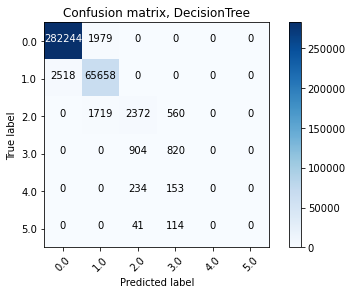

In [ ]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_temp,
                      title='Confusion matrix, DecisionTree')
plt.show()

RandomForest Classifier

In [ ]:
ran_forest = RandomForestClassifier(featuresCol = 'features', labelCol = 'Target')

In [ ]:
ran_forest_model = ran_forest.fit(train_df)

In [ ]:
y_pred_rf = ran_forest_model.transform(test_df)
y_pred_rf.show(5)

+-----+---------+----------+---+--------+------------------+---------------+---------+--------+----------+-------+---------+----------+-------+-------------------+-------------------+------+----+-----+----------+--------------------+--------------------+--------------------+----------+
|Index|CBSA_Code|      Date|AQI|Category|Defining_Parameter|Number_of_Sites|city_name|state_id|state_name|    lat|      lng|population|density|           timezone|Pollutant_Parameter|Target|year|month|dayofmonth|            features|       rawPrediction|         probability|prediction|
+-----+---------+----------+---+--------+------------------+---------------+---------+--------+----------+-------+---------+----------+-------+-------------------+-------------------+------+----+-----+----------+--------------------+--------------------+--------------------+----------+
|    0|    10140|2022-01-01| 21|    Good|             PM2.5|              2| Aberdeen|      WA|Washington|46.9757|-123.8094|     16571|    

In [ ]:
y_pred_rf.select('Target','rawPrediction', 'probability', 'prediction').show()

+------+--------------------+--------------------+----------+
|Target|       rawPrediction|         probability|prediction|
+------+--------------------+--------------------+----------+
|   0.0|[19.1582388735467...|[0.95791194367733...|       0.0|
|   0.0|[19.1582388735467...|[0.95791194367733...|       0.0|
|   0.0|[19.1582388735467...|[0.95791194367733...|       0.0|
|   0.0|[19.1582388735467...|[0.95791194367733...|       0.0|
|   0.0|[19.1582388735467...|[0.95791194367733...|       0.0|
|   0.0|[19.1582388735467...|[0.95791194367733...|       0.0|
|   0.0|[19.1582388735467...|[0.95791194367733...|       0.0|
|   0.0|[19.1582388735467...|[0.95791194367733...|       0.0|
|   0.0|[19.1582388735467...|[0.95791194367733...|       0.0|
|   0.0|[19.1582388735467...|[0.95791194367733...|       0.0|
|   0.0|[19.1582388735467...|[0.95791194367733...|       0.0|
|   0.0|[19.1582388735467...|[0.95791194367733...|       0.0|
|   0.0|[19.1582388735467...|[0.95791194367733...|       0.0|
|   0.0|

Model Evaluation

In [ ]:
#check for accuracy
multi_evaluator_rf = MulticlassClassificationEvaluator(labelCol = "Target", metricName = "accuracy")

In [ ]:
multi_evaluator_rf.evaluate(y_pred_rf)

0.9807495352280444

In [ ]:
# Accuracy, Precision, f1-Score, Recall: Classification Report for Random Forest Classifier

ran_forest_metrics = MulticlassMetrics(y_pred_rf['Target','prediction'].rdd)

print("Accuracy",ran_forest_metrics.accuracy)
print("Precision",ran_forest_metrics.precision(1.0))
print("Recall",ran_forest_metrics.recall(1.0))
print("f1-Score",ran_forest_metrics.fMeasure(1.0))

C:\spark-3.3.0-bin-hadoop3\python\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy 0.9807495352280444
Precision 1.0
Recall 0.9078875527679011
f1-Score 0.95172019069024


In [ ]:
from sklearn.metrics import confusion_matrix
y_true = y_pred_rf.select("Target")
y_true = y_true.toPandas()

y_pred = y_pred_rf.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_temp)
cnf_matrix

array([[284223,      0,      0,      0,      0,      0],
       [     0,  68176,      0,      0,      0,      0],
       [     0,   4651,      0,      0,      0,      0],
       [     0,   1724,      0,      0,      0,      0],
       [     0,    387,      0,      0,      0,      0],
       [     0,    155,      0,      0,      0,      0]], dtype=int64)

Confusion matrix, without normalization
[[284223      0      0      0      0      0]
 [     0  68176      0      0      0      0]
 [     0   4651      0      0      0      0]
 [     0   1724      0      0      0      0]
 [     0    387      0      0      0      0]
 [     0    155      0      0      0      0]]


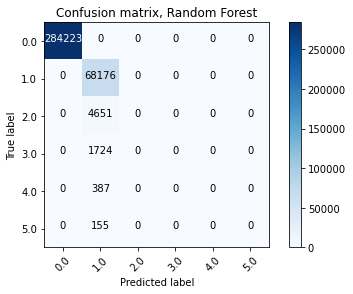

In [ ]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_temp,
                      title='Confusion matrix, Random Forest')
plt.show()

Logistic Regression

In [ ]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'Target')

In [ ]:
lr_model = lr.fit(train_df)

In [ ]:
y_pred = lr_model.transform(test_df)

In [ ]:
y_pred.show(5)

+-----+---------+----------+---+--------+------------------+---------------+---------+--------+----------+-------+---------+----------+-------+-------------------+-------------------+------+----+-----+----------+--------------------+--------------------+--------------------+----------+
|Index|CBSA_Code|      Date|AQI|Category|Defining_Parameter|Number_of_Sites|city_name|state_id|state_name|    lat|      lng|population|density|           timezone|Pollutant_Parameter|Target|year|month|dayofmonth|            features|       rawPrediction|         probability|prediction|
+-----+---------+----------+---+--------+------------------+---------------+---------+--------+----------+-------+---------+----------+-------+-------------------+-------------------+------+----+-----+----------+--------------------+--------------------+--------------------+----------+
|    0|    10140|2022-01-01| 21|    Good|             PM2.5|              2| Aberdeen|      WA|Washington|46.9757|-123.8094|     16571|    

In [ ]:
y_pred.select('Target','rawPrediction', 'probability', 'prediction').show()

+------+--------------------+--------------------+----------+
|Target|       rawPrediction|         probability|prediction|
+------+--------------------+--------------------+----------+
|   0.0|[4224.17768144131...|[1.0,0.0,0.0,0.0,...|       0.0|
|   0.0|[5307.21033186125...|[1.0,0.0,0.0,0.0,...|       0.0|
|   0.0|[4584.94339048049...|[1.0,0.0,0.0,0.0,...|       0.0|
|   0.0|[4464.44297969996...|[1.0,0.0,0.0,0.0,...|       0.0|
|   0.0|[4705.00248727957...|[1.0,0.0,0.0,0.0,...|       0.0|
|   0.0|[4945.56199485918...|[1.0,0.0,0.0,0.0,...|       0.0|
|   0.0|[4343.64835959846...|[1.0,0.0,0.0,0.0,...|       0.0|
|   0.0|[5185.97439777831...|[1.0,0.0,0.0,0.0,...|       0.0|
|   0.0|[4824.76737475769...|[1.0,0.0,0.0,0.0,...|       0.0|
|   0.0|[4583.91365785711...|[1.0,0.0,0.0,0.0,...|       0.0|
|   0.0|[4343.05994095654...|[1.0,0.0,0.0,0.0,...|       0.0|
|   0.0|[3741.14630569582...|[1.0,0.0,0.0,0.0,...|       0.0|
|   0.0|[5185.23887447590...|[1.0,0.0,0.0,0.0,...|       0.0|
|   0.0|

Model Evaluation

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
#check for accuracy
multi_evaluator = MulticlassClassificationEvaluator(labelCol = "Target", metricName = "accuracy")

In [ ]:
multi_evaluator.evaluate(y_pred)

0.9997690055549989

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics
lr_metrics = MulticlassMetrics(y_pred['Target','prediction'].rdd)

C:\spark-3.3.0-bin-hadoop3\python\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
# Accuracy, Precision, f1-Score, Recall: Classification Report for Logistic Regression Classifier

print("Accuracy",lr_metrics.accuracy)
print("Precision",lr_metrics.precision(1.0))
print("Recall",lr_metrics.recall(1.0))
print("f1-Score",lr_metrics.fMeasure(1.0))

Accuracy 0.9997690055549989
Precision 1.0
Recall 1.0
f1-Score 1.0


In [ ]:
from sklearn.metrics import confusion_matrix
y_true = y_pred.select("Target")
y_true = y_true.toPandas()

y_pred = y_pred.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_temp)
cnf_matrix

array([[284223,      0,      0,      0,      0,      0],
       [     0,  68176,      0,      0,      0,      0],
       [     0,      0,   4651,      0,      0,      0],
       [     0,      0,     14,   1680,     30,      0],
       [     0,      0,      0,      9,    354,     24],
       [     0,      0,      0,      0,      6,    149]], dtype=int64)

Confusion matrix, without normalization
[[284223      0      0      0      0      0]
 [     0  68176      0      0      0      0]
 [     0      0   4651      0      0      0]
 [     0      0     14   1680     30      0]
 [     0      0      0      9    354     24]
 [     0      0      0      0      6    149]]


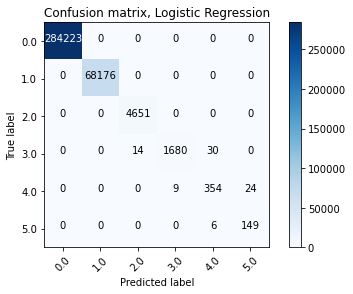

In [ ]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_temp,
                      title='Confusion matrix, Logistic Regression')
plt.show()